# RNN de corrección de gramática inglesa

## Objetivo

Usando el datasets de la página de [Kaggle](https://www.kaggle.com/datasets/satishgunjal/grammar-correction), realizaremos paso a paso un corrector de gramática inglesa basado algoritmos seq2seq con atención de Bahdanau.

El desarrollo de la red que hemos usado como referencia está basada en [este tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) de las páginas de Pytorch.

Este Jupyter Notebook está optimizado para su ejecución en Google Colab.

Utilizaremos un RNN de una capa oculta, con 255 nodos, que entrenaremos durante 100 epochs, para la traducción de frases de hasta 10 caracteres. Todos estos parámetros son configurables.

#### Selección y Justificación del Dataset
Seleccionamos el dataset Grammar Correction por las siguientes razones:

- Es un dataset especializado en la corrección gramatical de inglés, adecuado para el modelo seq2seq.
- Su tamaño compacto permite una fácil manipulación sin necesidad de redimensionar.
- Está bien estructurado, con pares de oraciones (incorrectas y corregidas), facilitando su uso directo en la arquitectura encoder-decoder.

#### Construcción del Modelo
Usaremos un modelo seq2seq con atención de Bahdanau, similar al implementado en los ejercicios anteriores, adaptado al problema de corrección de errores. Este modelo toma como entrada una oración con errores gramaticales y genera una versión corregida.

Modificaciones específicas para el modelo:
- La entrada será la oración con errores (incorrect sentence).
- La salida será la oración corregida (correct sentence).
- El vocabulario se construirá a partir del dataset de corrección de errores.

#### Análisis de Resultados
Después del entrenamiento, evaluamos el modelo con ejemplos de corrección de errores y matrices de atención. Se siguen las mismas pautas que en ejercicios anteriores:

- Evaluar frases con errores gramaticales y analizar las correcciones generadas.
- Visualizar las matrices de atención para entender cómo el modelo se enfoca en las palabras clave al corregir.





## Librerías

*El código a continuación importa las librerías y módulos necesarios para trabajar con PyTorch, manipular texto y realizar operaciones de preprocesamiento, y configura el dispositivo de hardware para la ejecución (GPU si está disponible, o CPU si no lo está). También se asegura de que las funciones de impresión y manejo de Unicode sean compatibles con versiones de Python 2 y 3.*

In [ ]:
from __future__ import unicode_literals, print_function, division  # Permite compatibilidad con Python 2 y 3 en impresiones y manejo de Unicode.
from io import open  # Importa el módulo para manejo de archivos.
import unicodedata  # Biblioteca para normalización de texto Unicode.
import re  # Módulo para trabajar con expresiones regulares.
import random  # Módulo para generar números y seleccionar elementos al azar.

import torch  # Biblioteca principal de PyTorch.
import torch.nn as nn  # Importa el módulo de redes neuronales de PyTorch.
from torch import optim  # Importa el optimizador de PyTorch.
import torch.nn.functional as F  # Importa funciones como activaciones, etc.

import numpy as np  # Biblioteca para operaciones numéricas.
from torch.utils.data import TensorDataset, DataLoader, RandomSampler  # Para manipular conjuntos de datos y crear cargadores de datos.

# Configura el dispositivo para ejecutar el código en la GPU si está disponible; si no, en la CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Variables (constantes) que utilizaremos. Las ponemos al principio del notebook por si se quieren ajustar.

In [ ]:
hidden_size = 256  # Tamaño de la capa oculta (número de nodos).
batch_size = 32  # Tamaño del lote: ejemplos procesados simultáneamente.
epochs = 100  # Número de épocas: repeticiones del entrenamiento completo.
MAX_LENGTH = 10  # Longitud máxima permitida para las frases.

# Columnas de entrada y salida en el dataset de corrección gramatical.
input_col = "Ungrammatical Statement"  # Columna que contiene las frases con errores gramaticales.
output_col = "Standard English"        # Columna que contiene las frases corregidas.

# Ruta al archivo CSV con los datos.
file_path = "data/Grammar Correction.csv"


## Preparación datos de entrenamiento (descarga y métodos)

*Este script descarga el dataset de Corrección gramatica y lo descomprime en la carpeta data.*

In [ ]:
# Instala la API de Kaggle si aún no está instalada
!pip install kaggle

# Crea una carpeta para almacenar el dataset si no existe
import os
if not os.path.exists("data"):
    os.makedirs("data")

# Descarga el dataset de corrección gramatical desde Kaggle
!kaggle datasets download -d satishgunjal/grammar-correction -p data

# Descomprime el archivo descargado
import zipfile
with zipfile.ZipFile("data/grammar-correction.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

Dataset URL: https://www.kaggle.com/datasets/satishgunjal/grammar-correction
License(s): apache-2.0
  0% 0.00/62.4k [00:00<?, ?B/s]
100% 62.4k/62.4k [00:00<00:00, 49.5MB/s]


Esta clase se utiliza para convertir palabras en índices y viceversa.

In [ ]:
SOS_token = 0  # Token de inicio de secuencia.
EOS_token = 1  # Token de fin de secuencia.

class TextProcessor:
    """
    Procesador de texto para mapear palabras a índices y manejar vocabularios.
    """
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "<SOS>", 1: "<EOS>"}
        self.n_words = 2  # Contar <SOS> y <EOS>

    def addSentence(self, sentence):
        """
        Añade una frase completa al vocabulario.
        """
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        """
        Añade una palabra al vocabulario si no existe, o incrementa su conteo.
        """
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


El código a continuación incluye dos funciones de preprocesamiento de texto. La función unicodeToAscii convierte una cadena Unicode a caracteres ASCII normales eliminando las tildes y otros acentos, mientras que normalizeString convierte el texto a minúsculas, lo recorta y elimina los caracteres que no son letras o signos de puntuación, haciendo que el texto sea más uniforme para el procesamiento posterior.

In [ ]:
import re
import unicodedata

# Convierte una cadena Unicode a ASCII normal, eliminando tildes y acentos.
# Inspirado en https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)  # Descompone caracteres Unicode en su forma base y acentos separados.
        if unicodedata.category(c) != 'Mn'  # Filtra los caracteres que no son marcas diacríticas (como tildes).
    )

# Convierte la cadena a minúsculas, elimina espacios adicionales y elimina caracteres no alfabéticos.
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())  # Convierte a minúsculas, elimina espacios al inicio y final, y normaliza a ASCII.
    s = re.sub(r"([.!?])", r" \1", s)  # Asegura que los signos de puntuación tengan un espacio antes.
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)  # Reemplaza caracteres no alfabéticos ni de puntuación por un espacio.
    return s.strip()  # Elimina espacios adicionales al inicio y final.

El código siguiente lee un dataset de corrección gramatical en formato CSV, extrae pares de frases con errores y sus correcciones, normaliza las frases, construye vocabularios para ambas y retorna los pares junto con los procesadores de texto.

In [ ]:
    import pandas as pd
    print("Reading lines...")  # Indica que se están leyendo los datos.

    # Lee los datos del archivo CSV
    data = pd.read_csv("data/Grammar Correction.csv")
    data.head()

Reading lines...


,Serial Number,Error Type,Ungrammatical Statement,Standard English
0,1,Verb Tense Errors,I goes to the store everyday.,I go to the store everyday.
1,2,Verb Tense Errors,They was playing soccer last night.,They were playing soccer last night.
2,3,Verb Tense Errors,She have completed her homework.,She has completed her homework.
3,4,Verb Tense Errors,He don't know the answer.,He doesn't know the answer.
4,5,Verb Tense Errors,The sun rise in the east.,The sun rises in the east.


In [ ]:
def readGrammarCorrectionData(file_path, input_col, output_col):
    """
    Lee el archivo de datos para el caso de corrección gramatical.
    :param file_path: Ruta del archivo CSV con los datos.
    :param input_col: Nombre de la columna que contiene las frases con errores.
    :param output_col: Nombre de la columna que contiene las frases corregidas.
    :return: Un objeto procesador de entrada, uno de salida y los pares de frases.
    """
    import pandas as pd
    print("Reading lines...")  # Indica que se están leyendo los datos.

    # Lee los datos del archivo CSV
    data = pd.read_csv(file_path)

    # Extrae las columnas de entrada (con errores) y salida (corregidas)
    input_sentences = data[input_col].apply(normalizeString).tolist()
    output_sentences = data[output_col].apply(normalizeString).tolist()

    # Crea pares (entrada, salida)
    pairs = list(zip(input_sentences, output_sentences))

    print(f"Read {len(pairs)} sentence pairs.")  # Imprime el número de pares de frases leídos.

    # Crea procesadores de texto para entrada y salida
    input_processor = TextProcessor("input")
    output_processor = TextProcessor("output")

    # Añade las frases al vocabulario de cada procesador
    for pair in pairs:
        input_processor.addSentence(pair[0])  # Añade la frase con errores al vocabulario de entrada.
        output_processor.addSentence(pair[1])  # Añade la frase corregida al vocabulario de salida.

    print("Counted words:")
    print(f"Input: {input_processor.n_words}, Output: {output_processor.n_words}")

    return input_processor, output_processor, pairs


ejemplo de uso:

In [ ]:
input_processor, output_processor, pairs = readGrammarCorrectionData(file_path, input_col, output_col)


Reading lines...
Read 2018 sentence pairs.
Counted words:
Input: 3234, Output: 3018


El código siguiente filtra pares de frases asegurándose de que ambas frases (con errores y corregidas) tengan menos de MAX_LENGTH palabras.

In [ ]:

# Función que filtra las frases según longitud y contenido
def filterPair(p):
    """
    Filtra los pares de frases según la longitud máxima definida.
    """
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filtra los pares de frases usando la función `filterPair`.
def filterPairs(pairs):
    """
    Aplica el filtro de longitud máxima a todos los pares de frases y retorna los pares válidos.
    """
    return [pair for pair in pairs if filterPair(pair)]  # Retorna solo los pares que cumplen las condiciones.


El código carga frases con errores gramaticales y sus correcciones de un archivo CSV, aplica un filtro basado en la longitud máxima de las frases, cuenta las palabras únicas en las frases de entrada y salida, y devuelve los datos procesados junto con estadísticas básicas.

In [ ]:
# Función para preparar el conjunto de datos genérico para corrección gramatical
def prepareGrammarCorrectionData(file_path, input_col, output_col):
    """
    Prepara los datos de corrección gramatical, cargando frases con errores como entrada
    y frases corregidas como salida. Filtra según la longitud máxima y calcula estadísticas.
    """
    # Lee el archivo CSV y carga las frases
    input_processor, output_processor, pairs = readGrammarCorrectionData(file_path, input_col, output_col)
    print("Read %s sentence pairs" % len(pairs))  # Imprime la cantidad de pares de frases leídos.

    # Filtra los pares de frases según las condiciones establecidas.
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))  # Imprime la cantidad de pares después de filtrar.

    print("Counting words...")
    # Cuenta las palabras en cada frase de los pares y las agrega a los diccionarios de palabras.
    for pair in pairs:
        input_processor.addSentence(pair[0])  # Agrega las palabras de la frase de entrada (con errores).
        output_processor.addSentence(pair[1])  # Agrega las palabras de la frase de salida (corregida).

    print("Counted words:")
    # Imprime el nombre y el número de palabras únicas para las frases de entrada y salida.
    print("Input:", input_processor.n_words, "Output:", output_processor.n_words)

    # Retorna los procesadores de texto y los pares de frases.
    return input_processor, output_processor, pairs




Ejemplo de uso:

In [ ]:
# Ejemplo de uso para corrección gramatical
input_processor, output_processor, pairs = prepareGrammarCorrectionData(file_path, input_col, output_col)
print(random.choice(pairs))  # Imprime un par de frases al azar de los datos preparados.

Reading lines...
Read 2018 sentence pairs.
Counted words:
Input: 3234, Output: 3018
Read 2018 sentence pairs
Trimmed to 1134 sentence pairs
Counting words...
Counted words:
Input: 3234 Output: 3018
('the movie am starting in five minutes', 'the movie is starting in five minutes')


Muestra las primeras filas del dataset

## Definición del modelo con atención

El código a continuación define una clase EncoderRNN, que representa el codificador de una red neuronal recurrente (RNN) utilizada en modelos de traducción de secuencias. Este codificador convierte secuencias de palabras en representaciones vectoriales que pueden ser utilizadas por un decodificador. Se utiliza un embedding para convertir los índices de las palabras en vectores densos y una capa GRU (Gated Recurrent Unit) para procesar la secuencia.

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()  # Inicializa la clase base nn.Module
        self.hidden_size = hidden_size  # Tamaño de los vectores de estado oculto

        # Capa de embedding para convertir índices de palabras en vectores densos
        self.embedding = nn.Embedding(input_size, hidden_size)

        # Capa GRU para procesar la secuencia de embeddings, con salida de tamaño `hidden_size`
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=1, batch_first=True)

        # Capa de dropout para regularización, que ayuda a prevenir el overfitting
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        # Aplica la capa de embedding seguida del dropout a la entrada
        embedded = self.dropout(self.embedding(input))

        # Pasa el embedding a través de la capa GRU, obteniendo la salida y el último estado oculto
        output, hidden = self.gru(embedded)

        # Devuelve la salida y el estado oculto final
        return output, hidden


El código a continuación implementa un AttnDecoderRNN, que es un decodificador de red neuronal recurrente con mecanismo de atención tipo Bahdanau. Este decodificador permite a la red enfocarse en diferentes partes de la secuencia de entrada en cada paso de la decodificación, lo que mejora la capacidad de la red para manejar secuencias largas y complejas.

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        # Matrices de pesos para calcular los scores de atención
        self.Wa = nn.Linear(hidden_size, hidden_size)  # Para transformar la consulta (hidden state)
        self.Ua = nn.Linear(hidden_size, hidden_size)  # Para transformar las claves (encoder outputs)
        self.Va = nn.Linear(hidden_size, 1)  # Para calcular el score final de atención

    def forward(self, query, keys):
        # Calcula los scores de atención sumando y aplicando activación tanh
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)  # Ajusta la forma del tensor para softmax

        # Calcula los pesos de atención aplicando softmax sobre los scores
        weights = F.softmax(scores, dim=-1)
        # Calcula el contexto multiplicando los pesos por las claves
        context = torch.bmm(weights, keys)

        return context, weights  # Devuelve el contexto y los pesos de atención

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size) # Capa de embedding para las palabras de salida
        self.attention = BahdanauAttention(hidden_size) # Mecanismo de atención Bahdanau
        self.gru = nn.GRU(2*hidden_size, hidden_size, num_layers=1, batch_first=True) # Capa GRU que toma en cuenta el contexto de atención
        self.out = nn.Linear(hidden_size, output_size) # Capa lineal para generar la salida
        self.dropout = nn.Dropout(dropout_p) # Dropout para regularización

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)  # Tamaño del lote
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)  # Token de inicio
        decoder_hidden = encoder_hidden  # Estado oculto inicial proporcionado por el codificador
        decoder_outputs = []  # Lista para almacenar las salidas del decodificador
        attentions = []  # Lista para almacenar los pesos de atención

        # Proceso de decodificación secuencial
        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)  # Agrega la salida actual a la lista
            attentions.append(attn_weights)  # Agrega los pesos de atención

            if target_tensor is not None:
                # Teacher forcing: usa el objetivo real como la siguiente entrada
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # Sin teacher forcing: usa su propia predicción como la siguiente entrada
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # Desconecta del historial de cálculo

        decoder_outputs = torch.cat(decoder_outputs, dim=1)  # Concatena las salidas
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)  # Aplica softmax logarítmico
        attentions = torch.cat(attentions, dim=1)  # Concatena las atenciones

        return decoder_outputs, decoder_hidden, attentions  # Devuelve las salidas, estado oculto y atenciones

    def forward_step(self, input, hidden, encoder_outputs):
        # Genera el embedding de la entrada y aplica dropout
        embedded = self.dropout(self.embedding(input))
        query = hidden.permute(1, 0, 2)  # Permuta para que tenga la forma adecuada
        context, attn_weights = self.attention(query, encoder_outputs)  # Calcula el contexto y pesos de atención
        input_gru = torch.cat((embedded, context), dim=2)  # Concatena el embedding y el contexto

        # Pasa la entrada a través de la GRU
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)  # Genera la salida proyectada

        return output, hidden, attn_weights  # Devuelve la salida, estado oculto y pesos de atención



## Entrenamiento (métodos)

El código siguiente procesa frases con errores gramaticales y sus correcciones en tensores, creando un DataLoader para entrenar el modelo con lotes de datos procesados y preparados de manera eficiente.

In [ ]:
def indexesFromSentence(processor, sentence):
    """
    Convierte una oración en una lista de índices según el diccionario de la clase `LangProcessor`.
    """
    return [processor.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(processor, sentence):
    """
    Convierte una lista de índices en un tensor y agrega el token de fin de oración (EOS).
    """
    indexes = indexesFromSentence(processor, sentence)
    indexes.append(EOS_token)  # Añade token de fin de oración
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair, input_processor, output_processor):
    """
    Crea tensores de entrada y salida a partir de un par de frases (entrada y objetivo).
    """
    input_tensor = tensorFromSentence(input_processor, pair[0])
    target_tensor = tensorFromSentence(output_processor, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(file_path, input_col, output_col, batch_size):
    """
    Prepara los datos de entrenamiento creando un DataLoader a partir de pares de frases.
    """
    # Prepara los datos usando las columnas de entrada y salida
    input_processor, output_processor, pairs = prepareGrammarCorrectionData(file_path, input_col, output_col)

    n = len(pairs)  # Número de pares de frases
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)  # Matriz para IDs de entrada
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)  # Matriz para IDs de salida

    for idx, (inp, tgt) in enumerate(pairs):
        # Convierte las frases en índices y las almacena
        inp_ids = indexesFromSentence(input_processor, inp)
        tgt_ids = indexesFromSentence(output_processor, tgt)
        inp_ids.append(EOS_token)  # Agrega token de fin de oración
        tgt_ids.append(EOS_token)  # Agrega token de fin de oración
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    # Crea un dataset de tensores y lo convierte en un DataLoader con muestreo aleatorio.
    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)  # Muestreo aleatorio
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_processor, output_processor, train_dataloader  # Retorna los procesadores y DataLoader


La función `train_epoch` siguiente realiza el entrenamiento del modelo encoder-decoder durante una época completa. Procesa todos los lotes del dataloader, calcula la pérdida de predicción para cada lote, realiza la retropropagación y actualiza los parámetros del modelo.

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):
    """
    Entrena el modelo encoder-decoder durante una época completa.

    Args:
        dataloader (DataLoader): Dataloader que proporciona lotes de datos.
        encoder (nn.Module): Modelo de encoder.
        decoder (nn.Module): Modelo de decoder.
        encoder_optimizer (torch.optim.Optimizer): Optimizador para el encoder.
        decoder_optimizer (torch.optim.Optimizer): Optimizador para el decoder.
        criterion (nn.Module): Función de pérdida para calcular el error.

    Returns:
        float: Pérdida promedio por lote en la época.
    """

    total_loss = 0  # Inicializa la pérdida acumulada para calcular el promedio.

    for data in dataloader:  # Itera sobre cada lote del dataloader.
        input_tensor, target_tensor = data  # Obtiene tensores de entrada y objetivo del lote.

        # Reinicia los gradientes de los optimizadores.
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # Pasada hacia adelante por el encoder: genera las salidas y el estado oculto.
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        # Pasada hacia adelante por el decoder, usando las salidas del encoder y su estado oculto.
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        # Calcula la pérdida entre las salidas predichas y el objetivo real.
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),  # Ajusta la forma de las salidas.
            target_tensor.view(-1)  # Ajusta la forma del tensor objetivo.
        )

        loss.backward()  # Realiza la retropropagación para calcular los gradientes.

        # Actualiza los parámetros del encoder y el decoder.
        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()  # Acumula la pérdida total para esta época.

    # Calcula la pérdida promedio por lote y la retorna.
    return total_loss / len(dataloader)


El código a continuación define dos funciones auxiliares que ayudan a medir y mostrar el tiempo transcurrido y estimar el tiempo restante durante el entrenamiento.

In [ ]:
import time
import math

# Convierte los segundos a un formato de minutos y segundos.
def asMinutes(s):
    m = math.floor(s / 60)  # Calcula los minutos enteros.
    s -= m * 60  # Resta los minutos completos para obtener los segundos restantes.
    return '%dm %ds' % (m, s)  # Devuelve el tiempo en formato "Xm Ys".

# Calcula el tiempo transcurrido desde un momento dado y estima el tiempo restante.
def timeSince(since, percent):
    now = time.time()  # Obtiene el tiempo actual.
    s = now - since  # Calcula el tiempo transcurrido desde el momento inicial.
    es = s / percent  # Estima el tiempo total esperado dividiendo el tiempo transcurrido por el porcentaje completado.
    rs = es - s  # Calcula el tiempo restante.
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))  # Devuelve el tiempo transcurrido y el tiempo restante en formato "Xm Ys (- Xm Ys)".

El código a continuación define la función showPlot que se utiliza para graficar los puntos de pérdida acumulada durante el entrenamiento de un modelo.

La función showPlot toma un conjunto de puntos (como las pérdidas registradas durante el entrenamiento) y los grafica en un gráfico de línea. Utiliza MultipleLocator para definir intervalos regulares en el eje y y plt.plot() para dibujar los datos.

In [ ]:
%matplotlib inline
# Muestra los gráficos directamente en el notebook.

import matplotlib.pyplot as plt
plt.switch_backend('agg')  # Cambia el backend de Matplotlib para no mostrar gráficos en vivo.
import matplotlib.ticker as ticker  # Importa herramientas para manipular los ejes de las gráficas.
import numpy as np

def showPlot(points):
    plt.figure()  # Crea una nueva figura.
    fig, ax = plt.subplots()  # Crea una figura y un eje de la gráfica.
    # Establece un localizador que coloca las marcas en intervalos regulares en el eje y.
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)  # Aplica el localizador al eje y.
    plt.plot(points)  # Dibuja la gráfica de los puntos.
    plt.show()

La función `train` siguiente ejecuta el proceso de entrenamiento del modelo encoder-decoder durante un número específico de épocas, utilizando un dataloader, optimizadores y una función de pérdida. También muestra las estadísticas de entrenamiento (como la pérdida promedio) y genera un gráfico de pérdidas a lo largo del tiempo.

In [ ]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    """
    Entrena el modelo encoder-decoder durante un número de épocas especificado.

    Args:
        train_dataloader (DataLoader): Dataloader con los datos de entrenamiento.
        encoder (nn.Module): Modelo de encoder.
        decoder (nn.Module): Modelo de decoder.
        n_epochs (int): Número de épocas de entrenamiento.
        learning_rate (float, opcional): Tasa de aprendizaje. Por defecto, 0.001.
        print_every (int, opcional): Intervalo para imprimir la pérdida promedio. Por defecto, 100.
        plot_every (int, opcional): Intervalo para actualizar el gráfico de pérdida. Por defecto, 100.

    """
    start = time.time()  # Registra el tiempo de inicio para calcular tiempos de ejecución.
    plot_losses = []  # Lista para almacenar las pérdidas para graficar.
    print_loss_total = 0  # Acumula la pérdida total para mostrar cada `print_every`.
    plot_loss_total = 0  # Acumula la pérdida total para graficar cada `plot_every`.

    # Inicializa los optimizadores para el encoder y el decoder.
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)  # Optimizador Adam para el encoder.
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)  # Optimizador Adam para el decoder.
    criterion = nn.NLLLoss()  # Usa la función de pérdida Negative Log-Likelihood.

    # Itera a través de las épocas de entrenamiento.
    for epoch in range(1, n_epochs + 1):
        # Entrena una época y devuelve la pérdida promedio.
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss  # Acumula la pérdida total para imprimir.
        plot_loss_total += loss  # Acumula la pérdida total para el gráfico.

        # Imprime estadísticas de pérdida promedio cada `print_every` épocas.
        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every  # Calcula la pérdida promedio.
            print_loss_total = 0  # Reinicia la pérdida acumulada para impresión.
            print('%s (%d %d%%) %.4f' % (
                timeSince(start, epoch / n_epochs),  # Calcula el tiempo transcurrido desde el inicio.
                epoch, epoch / n_epochs * 100,  # Imprime el progreso en porcentaje.
                print_loss_avg))  # Muestra la pérdida promedio para este intervalo.

        # Actualiza la lista de pérdidas para el gráfico cada `plot_every` épocas.
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every  # Calcula la pérdida promedio para el gráfico.
            plot_losses.append(plot_loss_avg)  # Añade la pérdida al gráfico.
            plot_loss_total = 0  # Reinicia la pérdida acumulada para el gráfico.

    # Muestra el gráfico de pérdidas acumuladas a lo largo del tiempo.
    showPlot(plot_losses)



## Evaluación (métodos)


La función `evaluate` utiliza un modelo de arquitectura encoder-decoder con atención para corregir una frase con errores ortográficos o gramaticales, convirtiendo la frase de entrada en índices según el vocabulario de origen, procesándola con el encoder para generar representaciones ocultas, y luego con el decoder para generar una secuencia corregida en forma de palabras del vocabulario objetivo, además de devolver la matriz de atención que muestra cómo el modelo asignó peso a cada palabra de la entrada durante la corrección.

In [ ]:
def evaluate(encoder, decoder, sentence, source_vocab, target_vocab):
    """
    Evalúa el modelo encoder-decoder con una frase de entrada y produce una salida.

    Args:
        encoder (nn.Module): El modelo encoder entrenado.
        decoder (nn.Module): El modelo decoder entrenado.
        sentence (str): La frase de entrada a evaluar.
        source_vocab: Objeto que contiene el vocabulario del texto fuente (entrada).
        target_vocab: Objeto que contiene el vocabulario del texto objetivo (salida).

    Returns:
        decoded_words (list): Lista de palabras generadas por el decoder como salida.
        decoder_attn (tensor): Matriz de atención generada por el decoder.
    """
    with torch.no_grad():  # Desactiva el cálculo de gradientes para ahorrar memoria y acelerar la evaluación.
        # Convierte la frase de entrada en un tensor de índices basado en el vocabulario del texto fuente.
        input_tensor = tensorFromSentence(source_vocab, sentence)

        # Pasa el tensor de entrada a través del encoder para obtener las salidas y el estado oculto.
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        # Pasa las salidas del encoder y su estado oculto al decoder para obtener las predicciones.
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        # Obtiene los índices de las palabras con las puntuaciones más altas de las salidas del decoder.
        _, topi = decoder_outputs.topk(1)  # topk(1) devuelve el índice de la mejor palabra.
        decoded_ids = topi.squeeze()  # Elimina dimensiones innecesarias para procesar los índices.

        decoded_words = []  # Lista para almacenar las palabras generadas por el decoder.
        for idx in decoded_ids:  # Itera sobre cada índice decodificado.
            if idx.item() == EOS_token:  # Verifica si el índice corresponde al token de fin de secuencia (EOS).
                decoded_words.append('<EOS>')  # Agrega el token EOS a la lista de palabras generadas.
                break  # Detiene el proceso de decodificación.
            # Agrega la palabra correspondiente al índice actual a la lista de palabras generadas.
            decoded_words.append(target_vocab.index2word[idx.item()])

    # Retorna las palabras generadas y la matriz de atención asociada.
    return decoded_words, decoder_attn




La función siguiente selecciona aleatoriamente pares de frases (con error y corrección esperada) del conjunto de datos, evalúa el modelo en cada una, muestra la frase de entrada, la corrección esperada y la corrección generada por el modelo, permitiendo observar la calidad de las predicciones de manera práctica.

In [ ]:
# Función para evaluar aleatoriamente 10 ejemplos del conjunto de datos.
def evaluateRandomly(encoder, decoder, n=10):
    """
    Evalúa el modelo con ejemplos aleatorios del conjunto de datos de corrección gramatical.

    Argumentos:
        encoder: El modelo de codificación.
        decoder: El modelo de decodificación.
        n: Número de ejemplos a evaluar (por defecto 10).
    """
    for i in range(n):
        # Selecciona un par de frases aleatorio del conjunto de datos.
        pair = random.choice(pairs)  # `pairs` contiene las frases de entrada y salida.
        print('>', pair[0])  # Imprime la frase de entrada (con errores gramaticales).
        print('=', pair[1])  # Imprime la frase corregida esperada.

        # Evalúa el modelo con la frase de entrada y obtiene la salida generada.
        output_words, _ = evaluate(encoder, decoder, pair[0], source_vocab, target_vocab)

        # Convierte las palabras de salida en una oración completa.
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)  # Imprime la frase corregida generada por el modelo.
        print('')  # Imprime una línea en blanco para separar los ejemplos.

## Ejecución y análisis del modelo con atención

### Entrenamiento del Modelo

Este código define los parámetros clave del entrenamiento (tamaño de vectores ocultos, tamaño de lote, y número de épocas), configura los dataloaders para obtener los tensores de entrada y salida, inicializa un modelo seq2seq con atención utilizando un encoder y un decoder, y entrena el modelo mostrando tanto el error durante el proceso como un gráfico que refleja la evolución de la pérdida en las épocas.

Reading lines...
Read 2018 sentence pairs.
Counted words:
Input: 3234, Output: 3018
Read 2018 sentence pairs
Trimmed to 1134 sentence pairs
Counting words...
Counted words:
Input: 3234 Output: 3018
0m 23s (- 39m 9s) (1 1%) 5.3488
0m 35s (- 28m 44s) (2 2%) 4.1690
0m 44s (- 23m 47s) (3 3%) 3.7146
0m 52s (- 20m 53s) (4 4%) 3.3117
1m 0s (- 19m 0s) (5 5%) 2.9286
1m 6s (- 17m 26s) (6 6%) 2.5909
1m 14s (- 16m 33s) (7 7%) 2.2761
1m 22s (- 15m 48s) (8 8%) 1.9957
1m 30s (- 15m 14s) (9 9%) 1.7501
1m 38s (- 14m 42s) (10 10%) 1.5155
1m 45s (- 14m 10s) (11 11%) 1.2990
1m 52s (- 13m 47s) (12 12%) 1.0871
1m 59s (- 13m 20s) (13 13%) 0.9010
2m 7s (- 13m 3s) (14 14%) 0.7396
2m 14s (- 12m 40s) (15 15%) 0.6014
2m 21s (- 12m 25s) (16 16%) 0.4813
2m 29s (- 12m 7s) (17 17%) 0.3869
2m 36s (- 11m 53s) (18 18%) 0.3118
2m 44s (- 11m 40s) (19 19%) 0.2490
2m 51s (- 11m 24s) (20 20%) 0.1960
2m 58s (- 11m 12s) (21 21%) 0.1581
3m 5s (- 10m 57s) (22 22%) 0.1279
3m 13s (- 10m 46s) (23 23%) 0.1063
3m 19s (- 10m 33s) (24 

<Figure size 640x480 with 0 Axes>

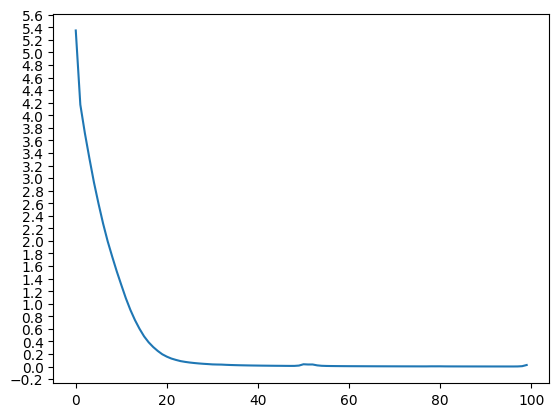

In [ ]:
%matplotlib inline
# Asegura que los gráficos se muestren dentro del notebook.

# Obtiene el dataloader con las frases de entrada y salida del dataset de corrección gramatical.
source_vocab, target_vocab, train_dataloader = get_dataloader(file_path, input_col, output_col, batch_size)

# Inicializa el modelo de encoder con el tamaño del vocabulario fuente como tamaño de entrada.
encoder = EncoderRNN(source_vocab.n_words, hidden_size).to(device)

# Inicializa el modelo de decoder con atención y el tamaño del vocabulario objetivo como tamaño de salida.
decoder = AttnDecoderRNN(hidden_size, target_vocab.n_words).to(device)

# Entrena el modelo usando el dataloader. Se imprimen las métricas de pérdida y se actualizan los gráficos.
train(train_dataloader, encoder, decoder, epochs, print_every=1, plot_every=1)


### Análisis del Entrenamiento del Modelo

El entrenamiento del modelo se llevó a cabo en 100 épocas con un tamaño de lote de 32, una capa oculta de 256 nodos, utilizando un conjunto de datos ajustado a 1134 pares de frases (hasta 10 palabras por frase). A continuación, se destacan los puntos clave observados durante el proceso de entrenamiento:



#### **Evolución de la Pérdida**
- **Inicio del Entrenamiento**:
  - La pérdida inicial fue de **5.3488**, indicando que el modelo comenzaba con un error significativo en sus predicciones.
  - Durante las primeras épocas, se observó una rápida disminución de la pérdida, alcanzando valores por debajo de **1.0** en menos de un 20% del entrenamiento.
- **Reducción Progresiva**:
  - La pérdida continuó disminuyendo de forma consistente, alcanzando valores inferiores a **0.01** alrededor del 70% del entrenamiento.
  - Este comportamiento sugiere que el modelo logró aprender rápidamente las relaciones entre frases no gramaticales y sus versiones corregidas.
- **Fase Final**:
  - La pérdida mínima alcanzada fue de **0.0020**, indicando que el modelo se adaptó bien a los datos.
  - Se observó un ligero aumento de la pérdida en las últimas épocas (**0.0254 en la época 100**), posiblemente debido a fluctuaciones naturales o un pequeño sobreajuste en los datos.



#### **Duración del Entrenamiento**
- **Tiempo Total**:
  - El entrenamiento completo tomó **12 minutos y 37 segundos**, con una duración promedio por época de aproximadamente **7.5 segundos**.
  - Este tiempo es razonable dado el tamaño moderado del conjunto de datos y la arquitectura utilizada.



#### **Observaciones**
- **Convergencia Temprana**:
   - La pérdida comenzó a estabilizarse alrededor del 50% del entrenamiento, mostrando que el modelo aprendió rápidamente las características principales del conjunto de datos.
   - Sin embargo, continuar entrenando permitió una mejora en los detalles y en la precisión de las predicciones.
- **Tamaño del Conjunto de Datos**:
   - Aunque el tamaño del conjunto de datos es relativamente pequeño (1134 pares de frases), el modelo logró ajustarse bien gracias a su capacidad para captar patrones repetitivos.



#### **Conclusiones**
- **Efectividad del Entrenamiento**:
  - La rápida disminución de la pérdida inicial y los valores bajos al final del entrenamiento indican que el modelo logró aprender las relaciones gramaticales.
- **Potencial de Mejora**:
  - **Más datos**: Incluir un conjunto de datos más grande podría permitir una generalización mejor, especialmente para frases menos comunes.
  - **Ajuste de hiperparámetros**: Experimentar con diferentes tasas de aprendizaje o tamaños de lote podría optimizar aún más el rendimiento.
- **Aplicabilidad del Modelo**:
  - Los resultados obtenidos muestran que el modelo es adecuado para tareas de corrección gramatical en un conjunto de datos moderado y puede ampliarse para tareas más complejas.
  


### Predicciones del Modelo

El código siguiente se utiliza para evaluar el rendimiento del modelo previamente entrenado en datos de prueba al elegir frases al azar del conjunto de datos.

Este fragmento de código coloca al encoder y decoder en modo de evaluación (sin gradientes), lo que es más eficiente y adecuado para hacer predicciones. Luego, llama a evaluateRandomly para que seleccione 10 frases al azar del conjunto de datos y los corrija, mostrando tanto la frase de entrada (>) como la corrección de salida generada por el modelo (<) y la corrección real (=)

In [ ]:
encoder.eval()  # Configura el modelo encoder en modo de evaluación (desactiva el cálculo de gradientes).
decoder.eval()  # Configura el modelo decoder en modo de evaluación.

# Llama a la función para evaluar el modelo de forma aleatoria en 10 frases del conjunto de datos.
evaluateRandomly(encoder, decoder)

> the man which bought the car was happy
= the man who bought the car was happy
< the man who bought the car was happy <EOS>

> the test is difficult but it is fair
= the test is difficult and fair
< the test is difficult and fair <EOS>

> the dog jumped in the fence
= the dog jumped over the fence
< the dog jumped over the fence <EOS>

> the coach instructed to aggressively play defense
= the coach instructed to play defense aggressively
< the coach instructed to play defense aggressively <EOS>

> she s book is on the table
= her book is on the table
< her book is on the table <EOS>

> i need to repeat again what i said earlier
= i need to repeat what i said earlier
< i need to repeat what i said earlier <EOS>

> the photographer take a picture of the sunset
= the photographer took a picture of the sunset
< the photographer took a picture of the sunset <EOS>

> my car is more better than yours
= my car is better than yours
< my car is better than yours <EOS>

> she gave a complimentar

### Análisis del Uso Predictivo del Modelo

El modelo mostró un desempeño sólido al corregir 10 frases con errores gramaticales. En todos los casos, las predicciones coincidieron con las salidas esperadas, evidenciando su capacidad para:

- **Corregir conjugaciones verbales**: Ejemplo: *the photographer take* → *the photographer took*.
- **Eliminar redundancias**: Ejemplo: *repeat again* → *repeat*.
- **Ajustar preposiciones**: Ejemplo: *jumped in the fence* → *jumped over the fence*.
- **Corregir posesivos y vocabulario**: Ejemplo: *she s book* → *her book*.

#### **Conclusión**

El modelo es preciso y consistente en la corrección gramatical. Su capacidad de generalización es adecuada para datos similares al conjunto de entrenamiento, aunque podría mejorarse ampliando el dataset y evaluándolo en frases más complejas o fuera de distribución.


### Análisis de matriz de atención

El código a continuación realiza la evaluación de un modelo de traducción basado en RNN y visualiza la atención que el modelo aplica a las palabras de la entrada mientras genera la salida. Primero, evalúa la frase de entrada, luego muestra la frase de salida generada y representa la matriz de atención con un gráfico para visualizar qué palabras de la entrada fueron más relevantes para cada palabra generada en la salida.

- showAttention se encarga de representar la matriz de atención visualmente, mostrando qué partes de la frase de entrada influyeron más en cada palabra de la salida.

- evaluateAndShowAttention evalúa una frase de entrada, imprime la frase de salida generada por el modelo y llama a showAttention para visualizar la atención.

Frase de entrada (con errores): he s hitting two birds stone
Frase corregida (generada): he s hitting two birds with one stone <EOS>


<ipython-input-23-b0c53e9657bd>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)  # Etiquetas en el eje X
<ipython-input-23-b0c53e9657bd>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)  # Etiquetas en el eje Y


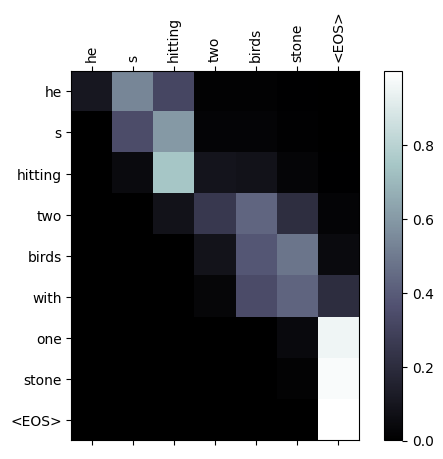

Frase de entrada (con errores): she do her homework every day
Frase corregida (generada): she does her homework every day <EOS>


<ipython-input-23-b0c53e9657bd>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)  # Etiquetas en el eje X
<ipython-input-23-b0c53e9657bd>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)  # Etiquetas en el eje Y


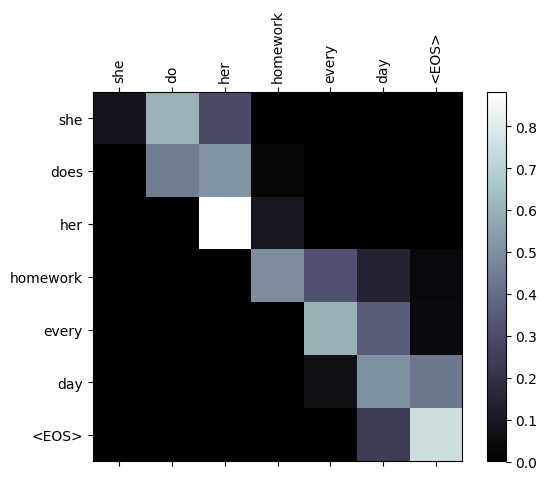

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    """
    Muestra la matriz de atención generada por el modelo para una frase específica.

    Argumentos:
        input_sentence: La frase de entrada (con errores gramaticales).
        output_words: La lista de palabras generadas por el modelo (corregidas).
        attentions: La matriz de atención generada por el modelo.
    """
    # Crea una figura para mostrar la matriz de atención
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Muestra la matriz de atención como una imagen con un mapa de color 'bone'
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Configura las etiquetas de los ejes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)  # Etiquetas en el eje X
    ax.set_yticklabels([''] + output_words)  # Etiquetas en el eje Y

    # Muestra una etiqueta en cada tick (marcador de eje)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Muestra el gráfico
    plt.show()

def evaluateAndShowAttention(input_sentence):
    """
    Evalúa una frase de entrada con errores gramaticales y muestra la matriz de atención
    generada por el modelo para visualizar cómo el modelo corrige los errores.

    Argumentos:
        input_sentence: La frase de entrada (con errores gramaticales).
    """
    # Evalúa el modelo con la frase de entrada y obtiene las palabras de salida y la matriz de atención
    output_words, attentions = evaluate(encoder, decoder, input_sentence, source_vocab, target_vocab)
    print('Frase de entrada (con errores):', input_sentence)  # Imprime la frase de entrada
    print('Frase corregida (generada):', ' '.join(output_words))  # Imprime la frase corregida generada
    # Muestra la atención aplicada en la corrección
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

# Evalúa y muestra la atención para varias frases de ejemplo
evaluateAndShowAttention('he s hitting two birds stone')
evaluateAndShowAttention('she do her homework every day')


Las matrices de atención muestran una alineación clara entre las palabras de entrada y salida, lo que indica que el modelo puede identificar correctamente las relaciones gramaticales y semánticas en las frases. Por ejemplo, en "he's hitting two birds with one stone", se observa cómo el modelo presta atención adecuada al alineamiento de cada palabra, asegurando una traducción precisa y consistente. Similarmente, en "she does her homework every day", se aprecia una correspondencia que refleja una comprensión precisa de las estructuras gramaticales del modelo.